## Example 2: Signal Search (GW Warm Up)
**Lecture:** Bayesian Statistical Inference

**Date:** 22/11/23

**Course:** Statistical Estimation for Physics

*Summary:* In this second example, we will give a very simplified illustration of using Bayesian inference to carry out signal searches. The goal is to highlight the type of likelihood-based approach typically taken here (e.g. looking at data residuals), and also how to deal with multi-dimensional posteriors to create a corner plot.

*Model:* The model is still quite simple: it has two model parameter $\theta = (f_0, A_0)$ that we want to infer. These specify the central frequency ($f_0$) and amplitude ($A_0$) of a integrated Gaussian signal template. Specifically, this is given by,

$$s(f | f_0, A_s) = \cfrac{A_s}{\sqrt{2 \pi \sigma^2}} \exp \left(-\cfrac{(f - f_0)^2}{2 \sigma^2}\right)$$

where we assume that $\sigma = 1$ is a known parameter. We assume the signal is measured in a detector across a variety of frequency bins $f_k$ such that the noise in each bin is distributed as uncorrelated standard normal Guassian random variables. In other words, the noise $n(f_i)$ in each bin is distributed as $n(f_i) \sim \mathcal{N}(0, 1)$.

Now, the data $x = n + s$ is a linear combination of the noise and signal. However, we know the distribution of the noise, so we can construct the following likelihood for the residual $(x - s)$:

$$p(x - s | \theta) = p(n) = \prod_{i}{\cfrac{1}{\sqrt{2 \pi}} \exp\left(-\cfrac{(x(f_i) - s(f_i | \theta))^2}{2}\right)}$$

which allows us to compute the log-likelihood via,

$$\log p(x - s | \theta) = -\sum_{i}{\left(x(f_i) - s(f_i | \theta)\right)^2} + \mathrm{const.}$$

where we have kept the additional temers that do not depend on $\theta$ as an additional fixed constant. This will be enough for us to compute the unnormalised posterior $p(\theta | x = s + n)$.

### Imports

In [1]:
#!pip install numpy matplotlib jax jaxlib
# Uncomment the above line to install the packages
import time
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from functools import partial

plt.style.use("lecture.mplstyle")
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

### Model Definition

Let's explore the model slightly, below we write some helper functions to define the signal template and generate the flat Gaussian noise.

Throughout we will take the frequency grid to be 100 bins equally distribution between $f = 0$ and $f = 20$.

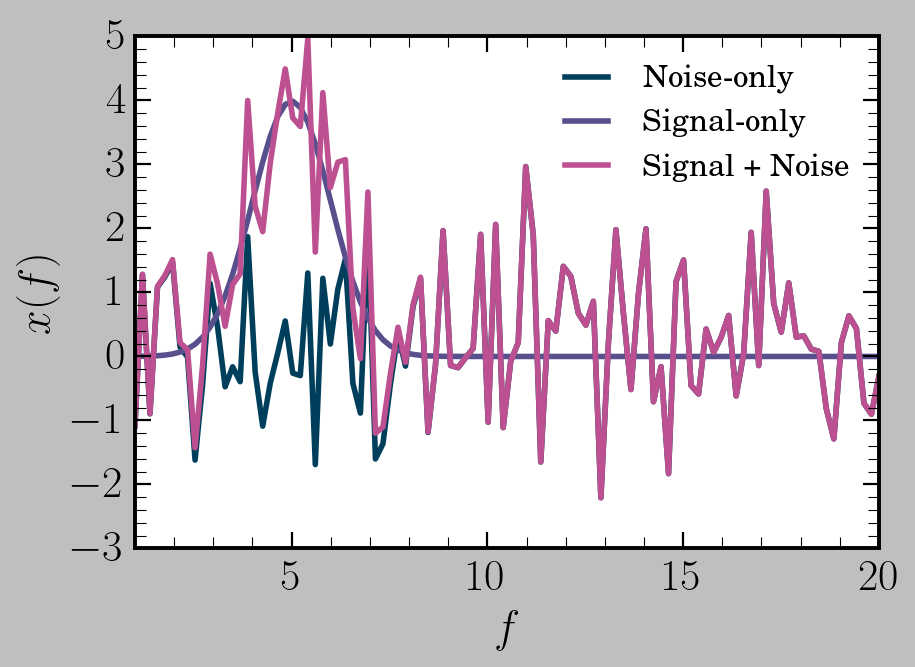

In [2]:
@jax.jit
def signal_template(freq_grid, theta):
    f0 = theta[..., 0]
    As = theta[..., 1]
    return As / (jnp.sqrt(2 * jnp.pi)) * jnp.exp(-0.5 * (freq_grid - f0) ** 2)


def generate_noise(freq_grid, key=None):
    if key is None: return jax.random.normal(jax.random.PRNGKey(time.time_ns()), shape=freq_grid.shape)
    else: return jax.random.normal(key, shape=freq_grid.shape)


freq_grid = jnp.linspace(1, 20, 100)
f0, As = 5, 10
theta = jnp.array([f0, As])
signal = signal_template(freq_grid, theta)
noise = generate_noise(freq_grid)
plt.plot(freq_grid, noise, label="Noise-only")
plt.plot(freq_grid, signal, label="Signal-only")
plt.plot(freq_grid, signal + noise, label="Signal + Noise")
plt.xlim(1, 20)
plt.xlabel(r"$f$")
plt.ylabel(r"$x(f)$")
plt.legend(fontsize=14)
plt.show()

### Definitions of the prior, likelihood, and posterior classes

Now we need to define a prior across the 2d-model space $(f_0, A_s)$. Let's assume we are looking for signals that could fall within the detection window, so in line with the frequency grid above, we take $p(f_0) \sim U(-1, 21)$ (accounting for the fact that we might be able to see a portion of the signal even if $f_0$ is outside the nominal range). Then, there is a physical minimum amplitude at $A_s = 0$, so let's take $p(A_s) \sim U(0, 20)$ (note that this upper limit is actually arbitrary, a good example of something we should check in general).

**Programming Note:** We have used the `functools` method `partial` to `jit`-compiile class methods

**Programming Note:** As mentioned above and hinted at in Example 1, we have coded up the log probabilities rather than the density directly. This is much, much better behaved numerically.

In [3]:
class Prior:
    def __init__(self):
        self.name = "prior"
        self.f0_min = 0.0
        self.f0_max = 21.0
        self.A_min = 0.0
        self.A_max = 20.0

    @partial(jax.jit, static_argnums=(0,))
    def log_density(self, theta):
        return jnp.log(
            (1.0 / (self.f0_max - self.f0_min))
            * (1.0 / (self.A_max - self.A_min))
            * jnp.heaviside(theta[..., 0] - self.f0_min, 1.0)
            * jnp.heaviside(self.f0_max - theta[..., 0], 1.0)
            * jnp.heaviside(theta[..., 1] - self.A_min, 1.0)
            * jnp.heaviside(self.A_max - theta[..., 1], 1.0)
        )

    def sample(self, size):
        return jax.random.uniform(
            jax.random.PRNGKey(time.time_ns()),
            shape=(size, 2),
            minval=jnp.array([self.f0_min, self.A_min]),
            maxval=jnp.array([self.f0_max, self.A_max]),
        )


class Likelihood:
    def __init__(
        self,
        sig_temp=signal_template,
        noise_generator=generate_noise,
        freq_grid=jnp.linspace(1, 20, 100),
    ):
        self.name = "likelihood"
        self.signal_template = sig_temp
        self.noise_generator = noise_generator
        self.freq_grid = freq_grid

    @partial(jax.jit, static_argnums=(0,))
    def log_density(self, x, theta):
        s = self.signal_template(self.freq_grid, theta)
        d = x - s
        return -2 * jnp.sum(d**2)

    def sample(self, theta, key=None):
        return self.signal_template(self.freq_grid, theta) + self.noise_generator(
            self.freq_grid, key
        )


class Posterior:
    def __init__(self, prior, likelihood):
        self.name = "posterior"
        self.prior = prior
        self.likelihood = likelihood

    @partial(jax.jit, static_argnums=(0,))
    def log_density(self, theta, x):
        return self.prior.log_density(theta) + self.likelihood.log_density(x, theta)

### Prior sampling check
Let's just do a quick check of the prior sampling to make sure we reproduce the uniform distributions

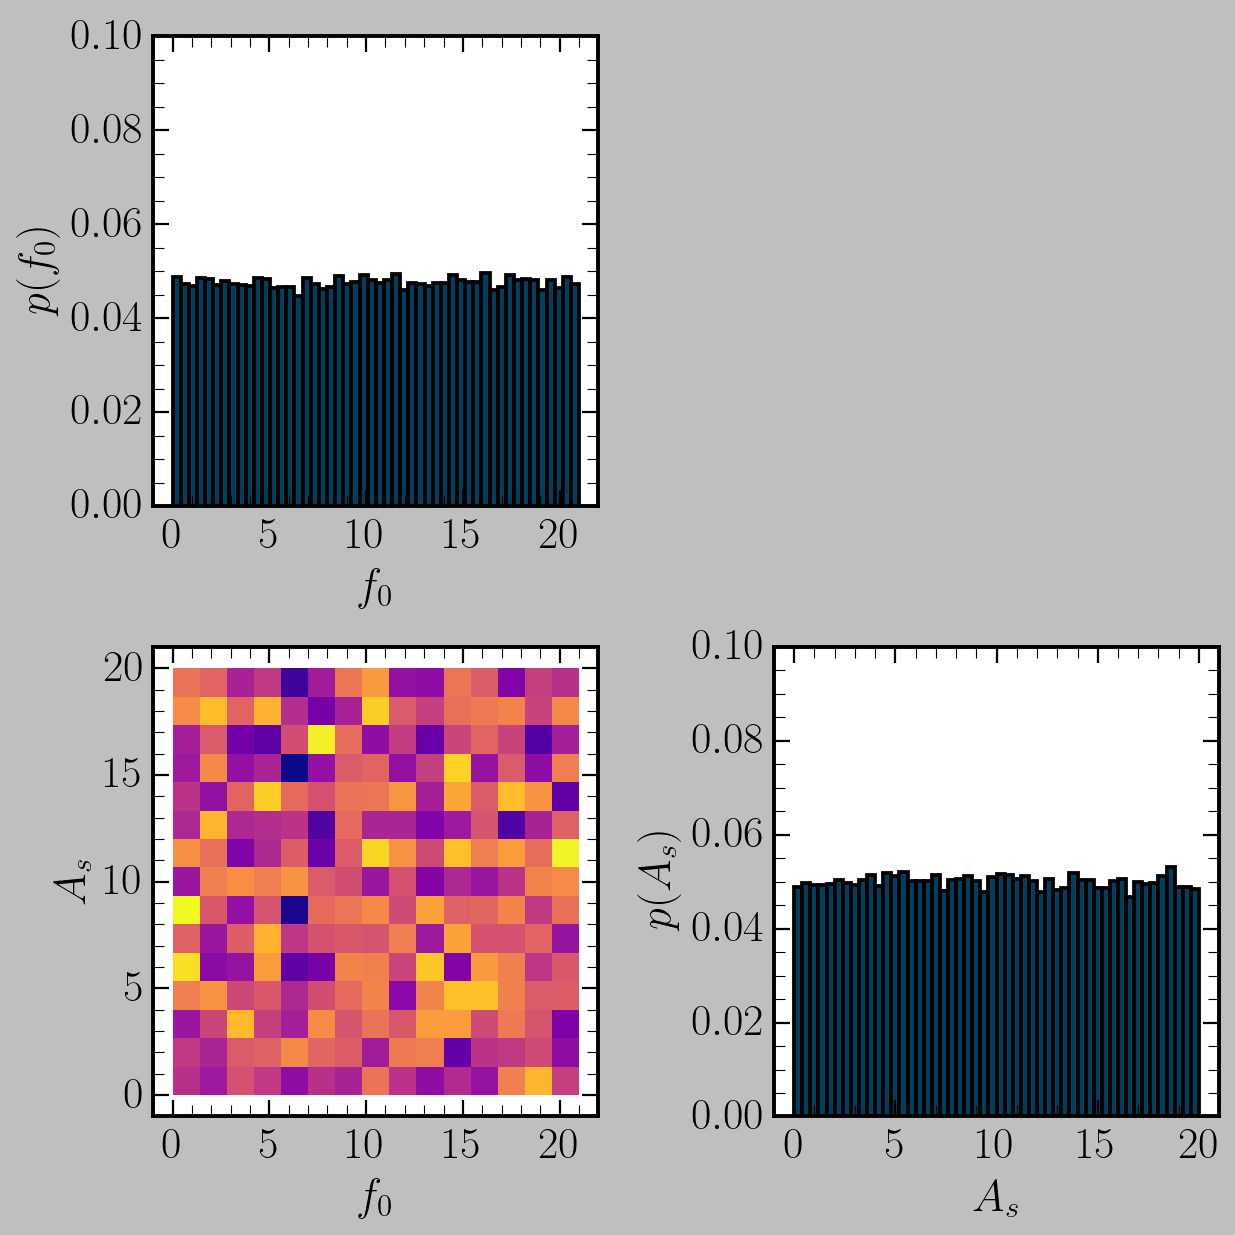

In [4]:
prior = Prior()
theta_sample = prior.sample(100000)

fig = plt.figure(figsize=(8, 8))
ax = plt.subplot(2, 2, 1)
plt.hist(theta_sample[:, 0], bins=50, density=True)
plt.xlabel(r"$f_0$")
plt.ylabel(r"$p(f_0)$")
plt.xlim(-1, 22)
plt.ylim(0, 0.1)

ax = plt.subplot(2, 2, 3)
plt.hist2d(
    theta_sample[:, 0],
    theta_sample[:, 1],
    bins=15,
    density=True,
    range=[[prior.f0_min, prior.f0_max], [prior.A_min, prior.A_max]],
)
plt.xlabel(r"$f_0$")
plt.ylabel(r"$A_s$")
plt.xlim(-1, 22)
plt.ylim(-1, 21)

ax = plt.subplot(2, 2, 4)
plt.hist(theta_sample[:, 1], bins=50, density=True)
plt.xlabel(r"$A_s$")
plt.ylabel(r"$p(A_s)$")
plt.xlim(-1, 21)
plt.ylim(0, 0.1)
plt.tight_layout()
plt.show()

### Likelihood evaluation

Now let's focus on the likelihood itself. We will do the same as we did in Example 1 and evaluate the likelihood on a grid for fixed data $x$. Again, if we re-run the results, we will see that for different realisations of the data, the likelihood profile shifts somewhat as a function of $\theta$.

**Programming Note:** We have tried to optimise the evaluations by using `jax.vmap` over the $\theta$ array

**Programming Note:** Note that we have used the flexibility of `jax`'s random number generator to have some control over the random sampling, so we can repeat the same experiment if desired.

### **Exercise:** Can you explain why we have substracted `true_log_max` when exponentiating the log likelihoods? (Note: This is cheating a bit here, normally we will not know the true maximum, what else could we do in this case?)

### **Exercise:** Try varying the input parameters (you will have to change the plotting range), how does the senstivity to the parameters depend on the input?

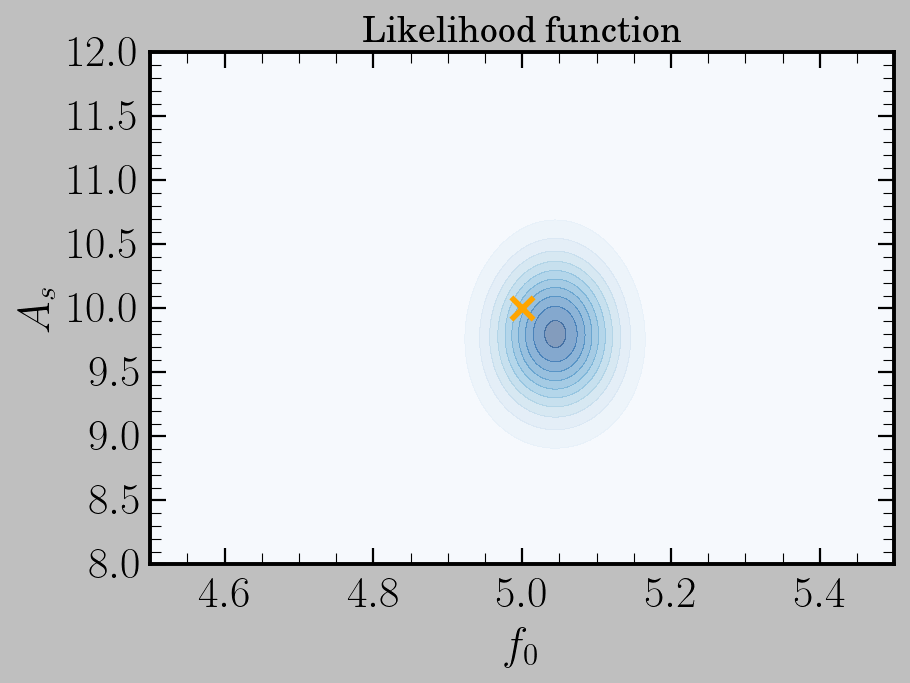

In [5]:
likelihood = Likelihood()
prior = Prior()
theta_true = jnp.array([5.0, 10.0])
N_samples = 1000
x_data = likelihood.sample(theta_true, key=jax.random.PRNGKey(0))
true_log_max = likelihood.log_density(x_data, theta_true)
theta_grids = jnp.meshgrid(
    jnp.linspace(4.2, 5.8, N_samples), jnp.linspace(8.0, 12.0, N_samples)
)
theta_arr = jnp.stack([theta_grids[0].flatten(), theta_grids[1].flatten()], axis=-1)
log_like_arr = jax.vmap(likelihood.log_density, in_axes=(None, 0))(x_data, theta_arr)
plt.contourf(
    theta_grids[0],
    theta_grids[1],
    jnp.exp(log_like_arr - true_log_max).reshape(N_samples, N_samples),
    cmap="Blues",
    alpha=0.5,
    levels=10,
)
plt.xlim(4.5, 5.5)
plt.ylim(8, 12)
plt.xlabel(r"$f_0$")
plt.ylabel(r"$A_s$")
plt.scatter(theta_true[0], theta_true[1], marker="x", color="orange", s=100)
plt.title("Likelihood function")
plt.show()

### Posterior Evaluation

Finally we can actually perform inference. As you can see in the `Posterior` class above, for a fixed observation $x_0$, we can easily compute the (unnormalised) log-posterior density by taking the sum of the prior and the likelihood as a function of $\theta$. Then, we can use the same tricks as above (i.e. the `jax.vmap` call) to efficiently compute the posterior on a grid of $\theta$ values.

### **Exercise:** Run this block multiple times (i.e. resample the data by changing the key), how does the posterior shift around? Can you relate that to the behaviour of the likelihood above? What happens if you vary the injection value of $\theta$ (again, you will have to change the plotting limits)?

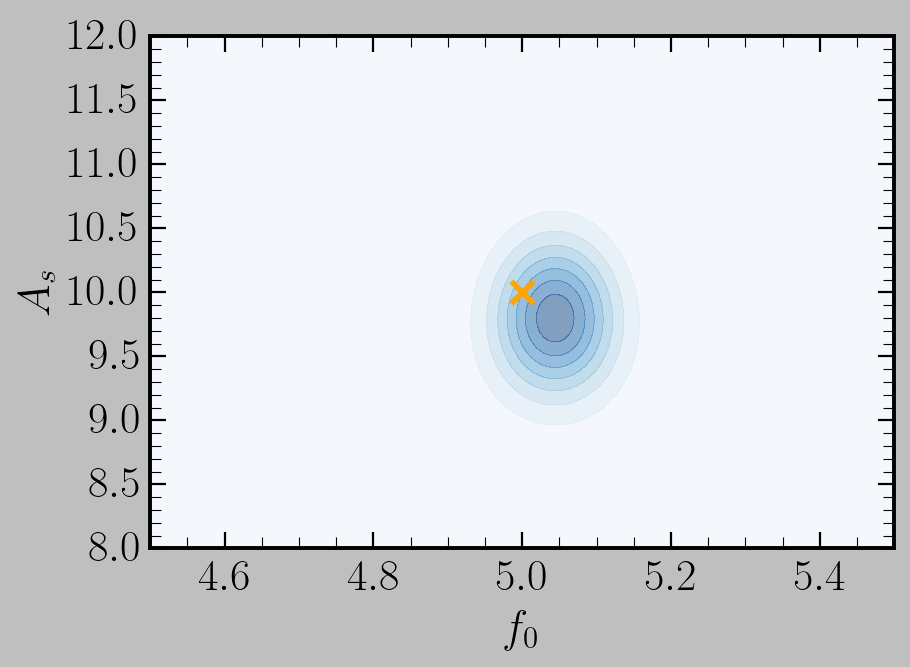

In [6]:
posterior = Posterior(prior=Prior(), likelihood=Likelihood())
theta_true = jnp.array([5.0, 10.0])
N_samples = 3000
x_data = likelihood.sample(theta_true, key=jax.random.PRNGKey(0))
true_post_max = posterior.log_density(theta_true, x_data)
theta_grids = jnp.meshgrid(
    jnp.linspace(4.2, 5.8, N_samples), jnp.linspace(8.0, 12.0, N_samples)
)
theta_arr = jnp.stack([theta_grids[0].flatten(), theta_grids[1].flatten()], axis=-1)
log_post_arr = jax.vmap(posterior.log_density, in_axes=(0, None))(theta_arr, x_data)

plt.contourf(
    theta_grids[0],
    theta_grids[1],
    jnp.exp(log_post_arr - true_post_max).reshape(N_samples, N_samples),
    cmap="Blues",
    alpha=0.5,
)
plt.xlim(4.5, 5.5)
plt.ylim(8, 12)
plt.xlabel(r"$f_0$")
plt.ylabel(r"$A_s$")
plt.scatter(theta_true[0], theta_true[1], marker="x", color="orange", s=100)
plt.show()

### Confidence Intervals and Corner Plots

A very standard output of this type of analysis in scientific literature is a so-called corner plot. This illustrates 1- and 2-dimensional marginal posteriors over the various model parameters, from which confidence intervals and marginalised parameter measurements can be computed. Below, we use a common package (`corner`) to plot our $\theta$ samples, weighted by the (unnormalised) posterior. Internally, `corner` is computing the area under the various 1- and 2-dimensional curves to extract confidence intervals, and also compute marginal distributions.

### **Exercise:** Try and compute the 1- and 2-sigma contours directly from the posterior by integrating. Try and compute the marginalised posteriors also (Hint: The marginal posterior for e.g. $f_0$ can be obtained by integrating the joint density: $p(f_0 | x) = \int{\mathrm{d}A_s \, p(f_0, A_s | x)}$).

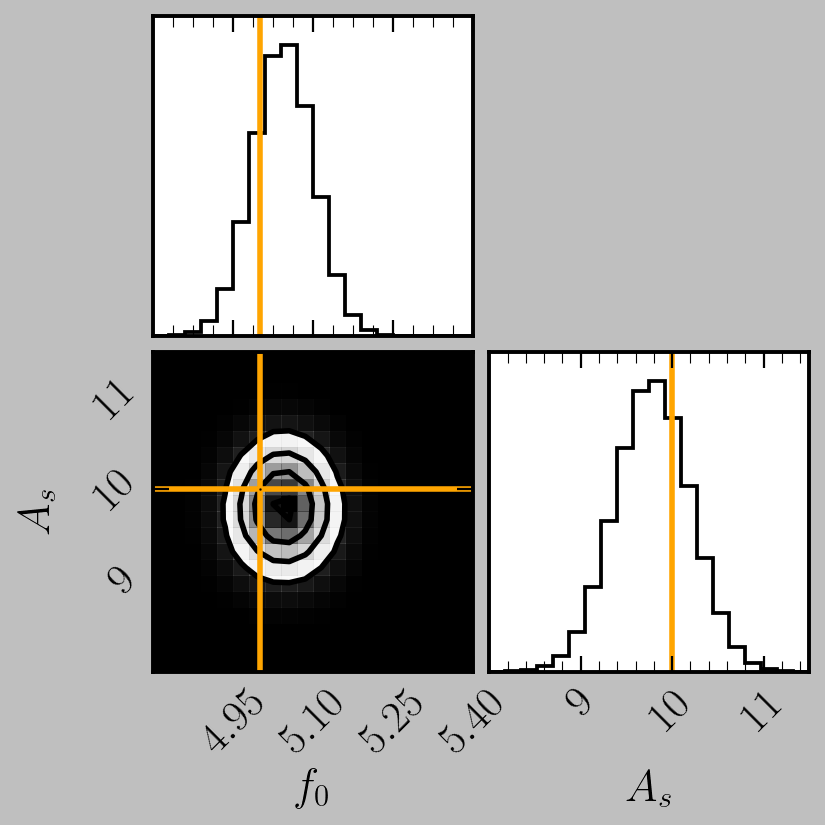

In [7]:
import corner
import numpy as np

corner.corner(
    np.array(theta_arr),
    weights=np.array(jnp.exp(log_post_arr - jnp.max(log_post_arr))),
    labels=[r"$f_0$", r"$A_s$"],
    truths=theta_true,
    bins=20,
    truth_color="orange",
    range=[[4.8, 5.4], [8.0, 11.5]],
)
plt.show()